# Wprowadzenie

Celem projektu była analiza danych z serwisu społecznościowego Reddit. W projekcie skupiono się na subredicie dotyczącym Astronomii, a z danych wyciągnięto interesujące wnioski. Warto zauważyć, że po ponownym uruchomieniu kodu zostaną zaciągnięte dane z ostatnich 30 dni, przez co wnioski mogą się zmieniać.

Do połączenia z API Reddita i zaciągnięcia danych użyto biblioteki PRAW (Python Reddit API Wrapper).

Dane tekstowe - komentarze na wstępie przetworzono, później także zagregowano je w zależności od daty publikacji i sentymentu. Dane podległy analizie sentymentu, wyodrębniono najbardziej popularne słowa - zamodelowano tematy (i zwizualizowano za pomocą chmur słów). Komentarze podległy również analizie szeregów czasowych, trendu (tu dla sentymentu i liczby komentarzy, w kodzie z ograniczeniem do 100 dziennie), a na samym końcu stworzono model predykcji wartości sentymentu na następne *n* dni.


# Uruchomienie

Aby zaciągnąć dane, należy podać swoje dane logowania do Reddit dla skonfigurowanego projektu (środowiska), np. korzystając z początku tego poradnika: https://latenode.com/blog/how-to-use-reddit-api-from-access-tokens-to-automated-data-collection

Już wcześniej został wygenerowany kod wynikowy działania programu, dla konkretnego, wcześniejszego przedziału czasowego. Można uruchomić go ponownie w celu analizy aktualnego czasu.

## Instalacja i import bibliotek

In [ ]:
!pip install asyncpraw openpyxl wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import asyncpraw
import re
import string
import nltk
import gensim
import seaborn as sns
import xgboost as xgb
from datetime import datetime, timedelta
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim import corpora
from asyncpraw.models import MoreComments

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Przetwarzanie tekstu

In [ ]:
# dodatkowe słowa do wyłączenia, których nie pokrywa nltk
common_words = {'like', 'would', 'could', 'just', 'know', 'think', 'get', 'go', 'make', 'really',
                'see', 'im', 'ive', 'used', 'much', 'enough', '1', 'dont', 'used', 'much', 'many',
                'also', 'quite', 'right', 'ur', 'u', 'one'}

In [ ]:
# stop words angielskie
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

# wstępne przetwarzanie tekstu (małe litery, usunięcie linków, znaków specjalnych + tokenizacja, sprowadzenie słów do formy podstawowej)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\n+", ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s,]', '', text)
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    text = re.sub(r"[-*,]+", '', text)
    words = word_tokenize(text)
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word not in common_words]

    return processed_words

In [ ]:
# dane logowania do Reddita
client_id = 'x'
client_secret = 'x'
user_agent = 'x'
username = 'x'
password = 'x'

## Pobieranie danych

In [ ]:
# łączenie z reddit api, ściągnięcie komentarzy z postów w subredicie o astronomii
async def fetch_data():
    reddit = asyncpraw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent,
                     username=username,
                     password=password)

    subreddit = await reddit.subreddit("Astronomy")
    comments_data = []

    # dane z ostatnich 30 dni
    thirty_days_ago = datetime.utcnow() - timedelta(days=30)
    time_threshold_unix = thirty_days_ago.timestamp()

    # limit 100 komentarzy dziennie
    comments_per_day = 100
    comments_by_day = {}

    # ściąganie danych z postów, limit 300
    async for post in subreddit.new(limit=300):
        if post.created_utc >= time_threshold_unix:
            await post.load()

            # dla każdego komentarza
            for comment in post.comments.list():
                # pomijamy "More Comments"
                if isinstance(comment, MoreComments):
                    continue

                # konwersja na bardziej czytelny format daty
                comment_time = datetime.utcfromtimestamp(comment.created_utc)
                comment_date = comment_time.strftime('%Y-%m-%d')

                # dodaj komentarz, jeśli jest z tego miesiąca
                if comment_date not in comments_by_day:
                    comments_by_day[comment_date] = []

                # jakie dane mają być zaciągnięte
                if len(comments_by_day[comment_date]) < comments_per_day:
                    comment_data = {
                        'title': post.title,
                        'body': post.selftext,
                        'comment': comment.body,
                        'created_at': comment_time.strftime('%Y-%m-%d %H:%M:%S'),
                    }
                    comments_by_day[comment_date].append(comment_data)

    # stwórz listę komentarzy
    for date, comments in comments_by_day.items():
        for comment in comments:
            comments_data.append(comment)

    await reddit.close()

    # zwróć df z danymi
    return pd.DataFrame(comments_data)


posts_df = await fetch_data()

In [ ]:
# przetwórz komentarze wcześniej przygotowaną funkcją
posts_df['processed_comments'] = posts_df['comment'].apply(preprocess_text)

posts_df.head()

,title,body,comment,created_at,processed_comments
0,"Milky Way core over GranTeCan telescope, La Pa...",,"Here’s a picture I took in La Palma, Canary Is...",2025-01-22 15:55:39,"[here, picture, took, la, palma, canary, islan..."
1,sunset/moonrise calculation,"at this location : 35°49'00.5""N 5°44'58.4""W , ...",Next time there is a full moon (and every time...,2025-01-22 12:03:24,"[next, time, full, moon, every, time, thereaft..."
2,sunset/moonrise calculation,"at this location : 35°49'00.5""N 5°44'58.4""W , ...",Assuming you don't want to use CSPICE or anoth...,2025-01-22 12:21:11,"[assuming, want, use, cspice, another, form, c..."
3,sunset/moonrise calculation,"at this location : 35°49'00.5""N 5°44'58.4""W , ...","Well, it's close, but if the full moon is *dir...",2025-01-22 12:19:51,"[well, close, full, moon, directly, opposite, ..."
4,sunset/moonrise calculation,"at this location : 35°49'00.5""N 5°44'58.4""W , ...","I did some research, and with the help of AI i...",2025-01-22 16:36:46,"[research, help, ai, quickly, able, generate, ..."


## Analiza sentymentu

In [ ]:
def analyze_sentiment(tokens):
    text = ' '.join(tokens)
    return sid.polarity_scores(text)['compound']

In [ ]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

# ocena sentymentu dla tekstu komentarza
posts_df['sentiment_score'] = posts_df['processed_comments'].apply(analyze_sentiment)

# kategoryzacja sentymentu na podstawie wartości
posts_df['sentiment'] = posts_df['sentiment_score'].apply(
    lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

posts_df[['comment', 'sentiment', 'sentiment_score']].head(40)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,comment,sentiment,sentiment_score
0,"Here’s a picture I took in La Palma, Canary Is...",positive,0.9584
1,Next time there is a full moon (and every time...,neutral,0.0000
2,Assuming you don't want to use CSPICE or anoth...,positive,0.0772
3,"Well, it's close, but if the full moon is *dir...",negative,-0.3111
4,"I did some research, and with the help of AI i...",negative,-0.0258
5,Camera type? Can you recall the exposure time/...,neutral,0.0000
6,"Well technically, if it is indeed something in...",positive,0.2732
7,Looks like ET on his bike,neutral,0.0000
8,"AI is ruining photography, most people don't e...",negative,-0.2500
9,My guess is helicopter,neutral,0.0000


## Topic modelling

In [ ]:
# przygotowanie danych pod model LDA
# częstotliwości powtarzających się słów w przechowywanych zdaniach
dictionary = corpora.Dictionary(posts_df['processed_comments'])
corpus = [dictionary.doc2bow(comment) for comment in posts_df['processed_comments']]

lda_model = gensim.models.LdaMulticore(corpus, num_topics=4, id2word=dictionary, passes=10)

### Wizualizacja

Topic 0: 0.011*"light" + 0.009*"star" + 0.009*"year" + 0.007*"zwo" + 0.007*"object" + 0.006*"filter" + 0.005*"time" + 0.004*"photo" + 0.004*"2" + 0.004*"minute"


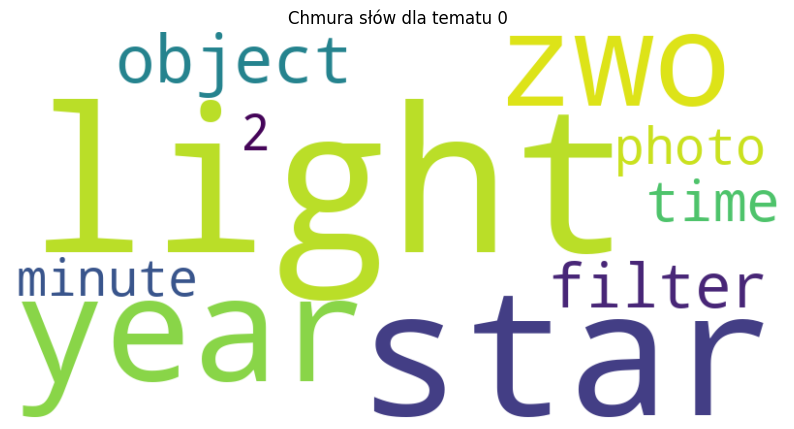

Topic 1: 0.013*"image" + 0.010*"look" + 0.010*"star" + 0.009*"photo" + 0.008*"nebula" + 0.008*"zwo" + 0.007*"eye" + 0.007*"telescope" + 0.006*"info" + 0.006*"camera"


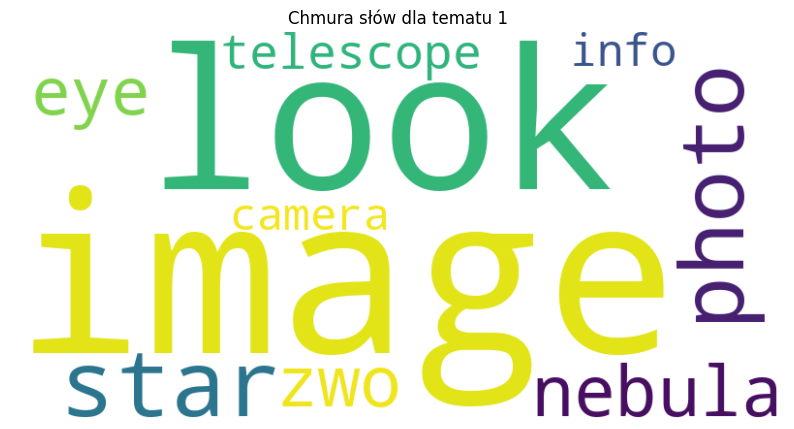

Topic 2: 0.012*"star" + 0.007*"night" + 0.006*"first" + 0.006*"look" + 0.006*"image" + 0.006*"sky" + 0.005*"magnitude" + 0.005*"find" + 0.004*"still" + 0.004*"day"


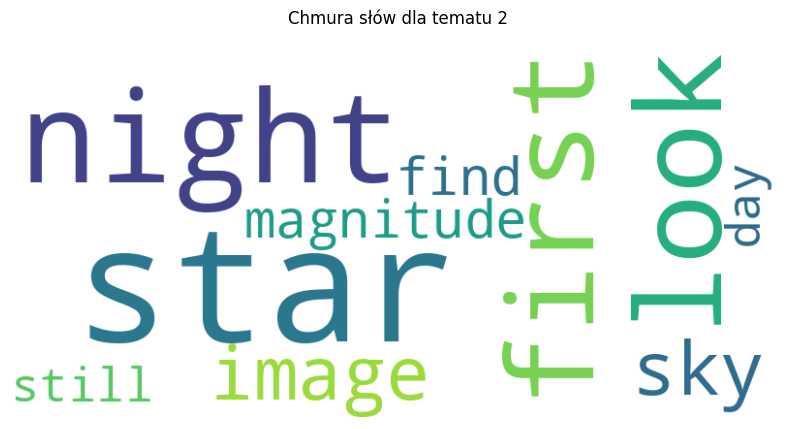

Topic 3: 0.016*"moon" + 0.012*"time" + 0.009*"thank" + 0.007*"planet" + 0.007*"even" + 0.006*"way" + 0.006*"thats" + 0.005*"telescope" + 0.005*"look" + 0.005*"thing"


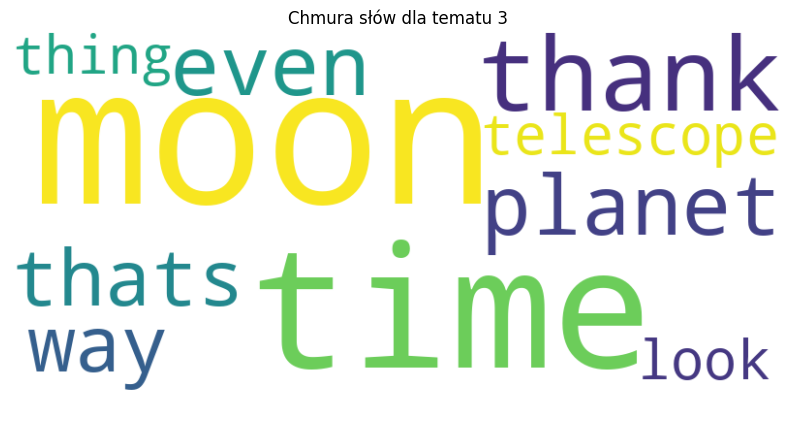

In [ ]:
# generowanie i wyświetlanie chmury słów dla każdego tematu
for topic_id, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic}")

    # przetwarzanie otrzymanych danych na chmurę słów
    topic_words = {}
    # podział na pary słowo-waga, czyszczenie, konwersja wartości
    for word in topic.split(' + '):
        word_weight = word.split('*')
        word = word_weight[1].strip().replace('"', '')
        weight = float(word_weight[0].strip())
        topic_words[word] = weight

    # generowanie chmury słów
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)

    # wizualizacja
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Chmura słów dla tematu {topic_id}")
    plt.axis('off')
    plt.show()

## Analiza trendu

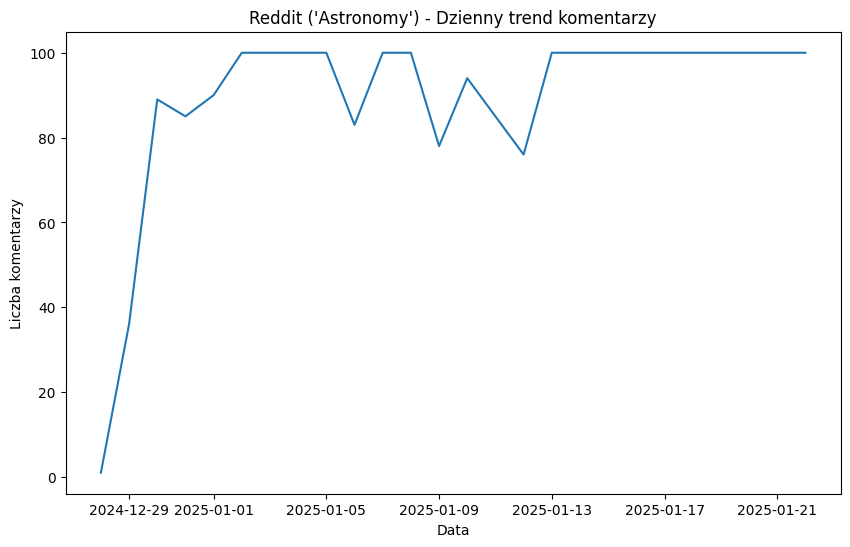

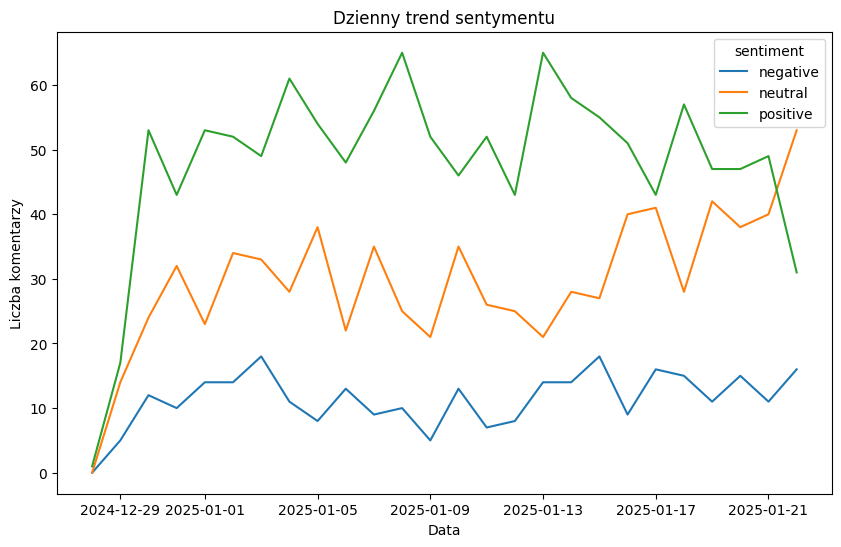

In [ ]:
# zmień format daty na dzienny
posts_df['created_at'] = pd.to_datetime(posts_df['created_at'])

# agregacja po dacie
posts_df['date'] = posts_df['created_at'].dt.date
daily_trend = posts_df.groupby('date').size()

# dzienny trend komentarzy - wizualizacja
daily_trend.plot(figsize=(10, 6))
plt.title("Reddit ('Astronomy') - Dzienny trend komentarzy")
plt.xlabel("Data")
plt.ylabel("Liczba komentarzy")
plt.show()

# + grupowanie na podstawie sentymentu
sentiment_trend = posts_df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

# dzienny trend sentymentu - wizualizacja
sentiment_trend.plot(kind='line', figsize=(10, 6))
plt.title("Dzienny trend sentymentu")
plt.xlabel("Data")
plt.ylabel("Liczba komentarzy")
plt.show()

### Dystrybucja group komentarzy (pozytywne, negatywne, neutralne)

<ipython-input-14-c2e50475af12>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


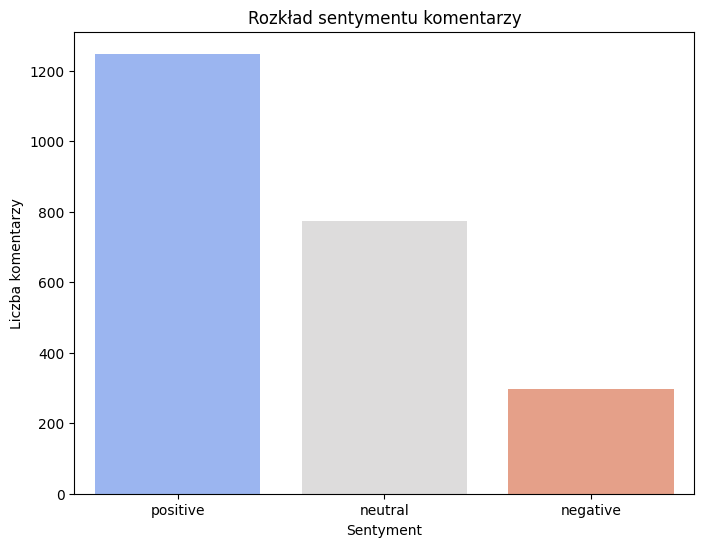

In [ ]:
# rozkład sentymentu komentarzy
sentiment_counts = posts_df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title("Rozkład sentymentu komentarzy")
plt.xlabel("Sentyment")
plt.ylabel("Liczba komentarzy")
plt.show()

## Predykcja sentymentu na kolejne dni

In [ ]:
# do uczenia konwersja labelek na wartości
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
posts_df['sentiment_numeric'] = posts_df['sentiment'].map(sentiment_mapping)

# grupowanie po dacie i średni sentyment dla dnia
posts_df = posts_df.sort_values('created_at')
posts_df['date'] = posts_df['created_at'].dt.date
daily_sentiment = posts_df.groupby('date').agg(
    sentiment_score=('sentiment_numeric', 'mean'),
    comment_count=('sentiment_numeric', 'size')
).reset_index()

daily_sentiment.set_index('date', inplace=True)

# większy zakres przesunięcia (dłuższy okres prognozy)
max_lag = 30
for i in range(1, max_lag + 1):
    posts_df[f'lag_{i}'] = posts_df['sentiment_numeric'].shift(i)

# usunięcie pustych kolumn po przesuwaniu danych
posts_df.dropna(inplace=True)

In [ ]:
# cechy z poprzednich dni
lag_columns = [f'lag_{i}' for i in range(1, max_lag + 1)]

# wartość sentymentu z poprzednich dni
X = posts_df[lag_columns]
# label sentymentu dla następnego komentarza
y = posts_df['sentiment_numeric']

In [ ]:
# podział danych na testowe i treningowe, bez przemieszania (zachowana chronologia)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xg_reg.fit(X_train, y_train)

# predykcja
y_pred = xg_reg.predict(X_test)

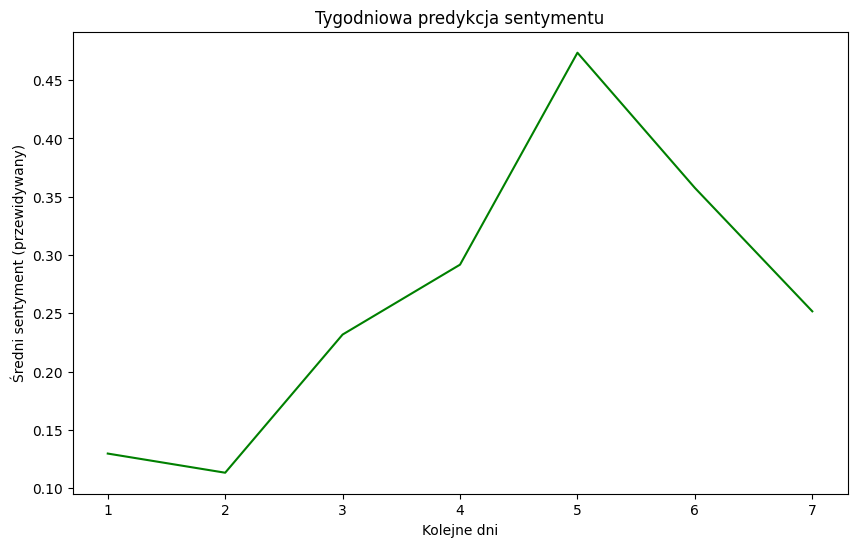

In [ ]:
# dane z ostatniej obserwacji
last_data_point = X_test.iloc[-1].values.reshape(1, -1)

# przewidywanie na następne dni
predicted_sentiment = []
for i in range(7):
    # ostatnia predykcja
    pred = xg_reg.predict(last_data_point)[0]
    predicted_sentiment.append(pred)

    # przesunięcie i predykcja następnego dnia
    last_data_point = np.roll(last_data_point, shift=-1, axis=1)
    last_data_point[0, -1] = pred

plt.figure(figsize=(10, 6))
plt.plot(range(1, 8), predicted_sentiment, label="Tygodniowa predykcja sentymentu", color='green')
plt.xlabel("Kolejne dni")
plt.ylabel("Średni sentyment (przewidywany)")
plt.title("Tygodniowa predykcja sentymentu")
plt.xticks(range(1, 8))
plt.show()

# Wnioski z wyników wygenerowanych (w terminie pracy nad projektem)

Jeśli chodzi o subredita o Astronomii, jest on miejscem, które zrzesza pasjonatów tej tematyki - świadczy o tym m.in. przeważajaca liczba pozytywnych komentarzy i całkiem spora neutralnych, negatywnych komentarzy jest znacznie mniej. Są one jednak zmienne w czasie, czasem pojawia się więcej komentarzy negatywnych kosztem pozytywnych, a peaki pozytywnych mogą być związane m.in. ze specjalnymi wydarzeniami na niebie.

Top wymodelowanych tematów będzie ulegał zmianom, jednak dostrzegalne są pojawiające się tematy związane z astrofotografią, obserwacją nieba, teleskopami czy zainteresowaniem planetami, gwiazdami i innymi obiektami takimi jak galaktyki i mgławice planetarne.

Subredit ten w poszczególnych dniach ma ponad 100 komentarzy, jednak można go niejako uznać za mniejszy, ponieważ w niektórych dniach liczba dzienna komentarzy nie przekracza 80.

